# LSTM for Pump Downtime Forecasting
### Author: Christian Grech

* Aim: using Lagged features and LSTM model to forecast pump downtime in advance.
* Techniques used: 
 - Feature importance,
 - LSTM, 
 - Early Stopping, 
 - Train/Valid/Test split, 
 - Feature lagging, 
 - Normalization

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score

import datetime
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pump-sensor-data/sensor.csv


## Data Cleaning and Exploration

Let's check for null values in our columns.

<AxesSubplot:>

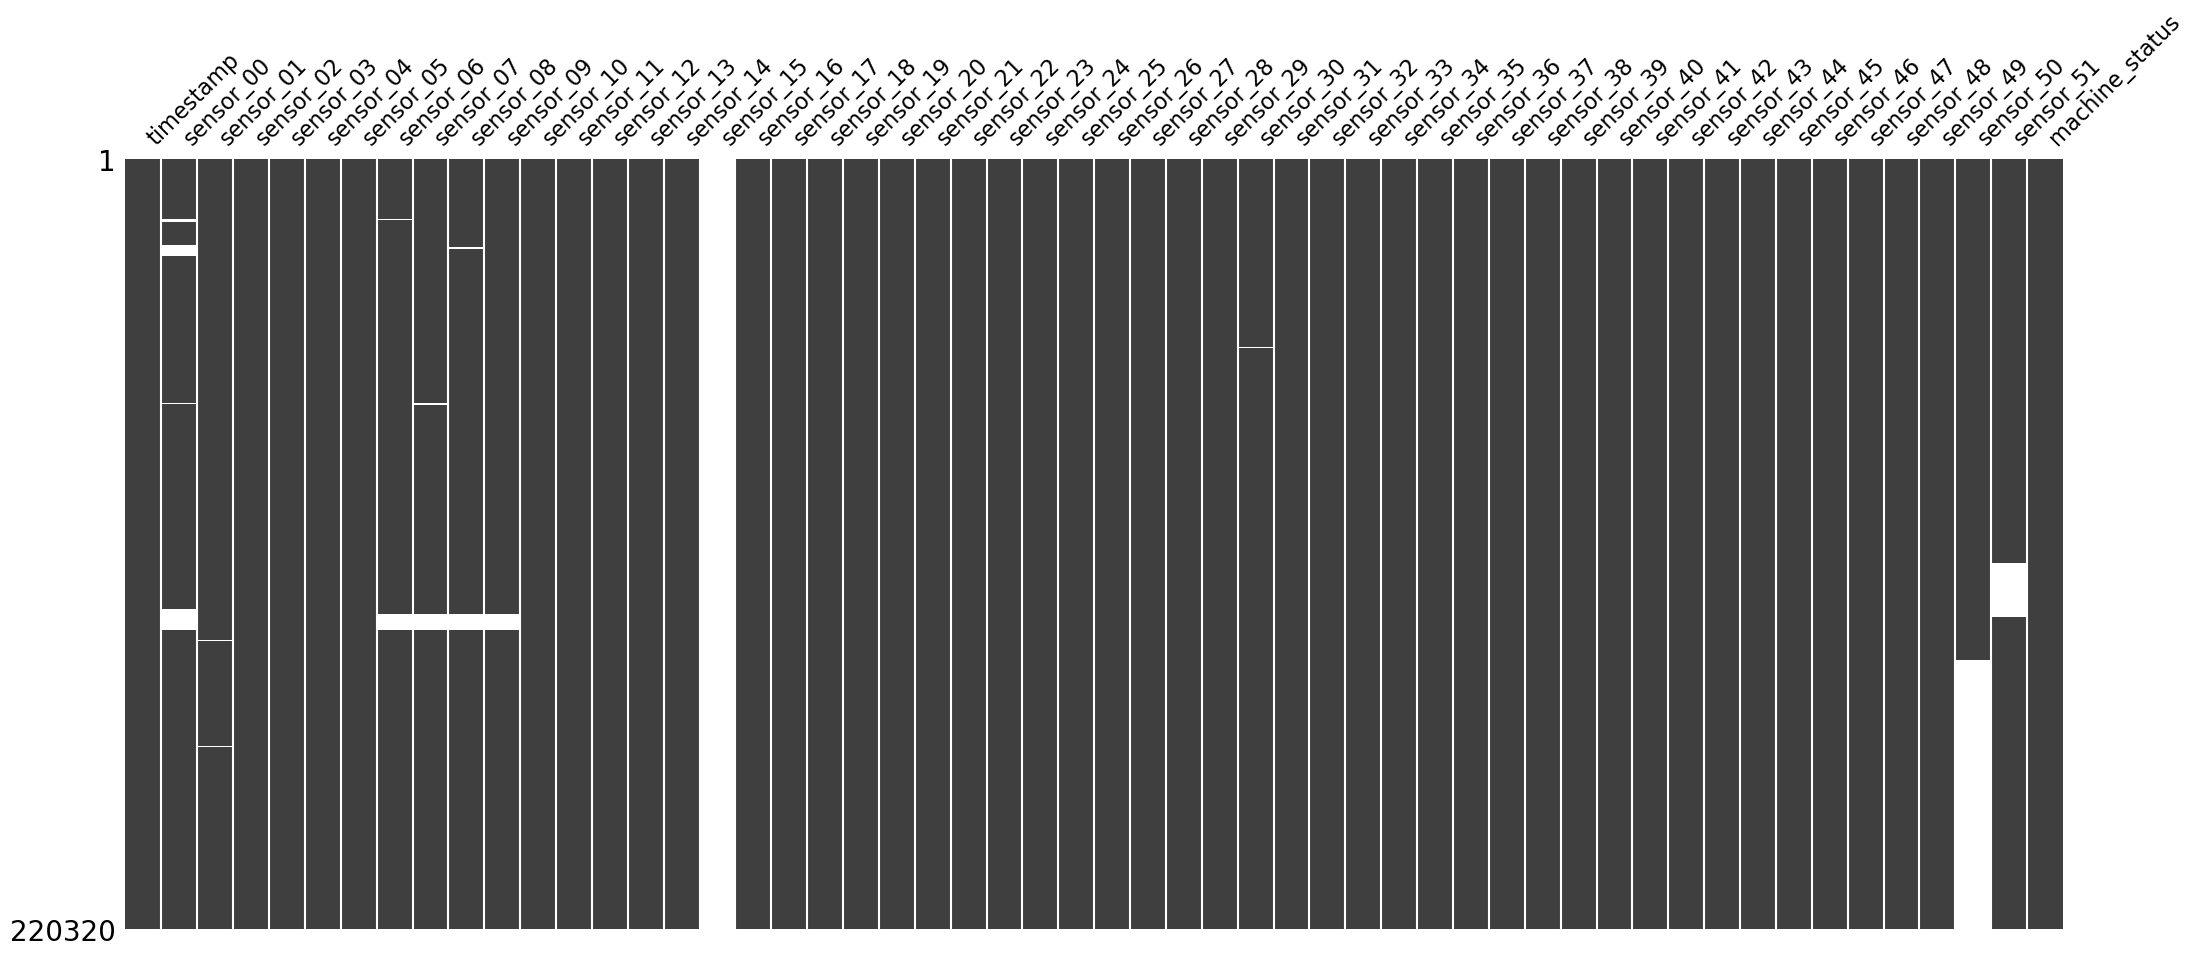

In [2]:
df = pd.read_csv(os.path.join(dirname, filename), index_col=0)
msno.matrix(df, labels=True, sparkline=False)

In [3]:
df['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [4]:
# Sensor 37 seems to consist of noise only so it is dropped
df.drop(['sensor_50','sensor_15', 'sensor_37'] , axis = 1 , inplace = True)
df.fillna(method = 'ffill' , inplace = True)

df['date'] = pd.to_datetime(df['timestamp'])
del df['timestamp']
df = df.set_index('date')

Let's explore any cyclic patterns which could help in forecasting:

In [5]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

Visualize one sensor to check how downtime happens. It looks like Downtime is represented by a Broken label followed by a number of Recovering labels.

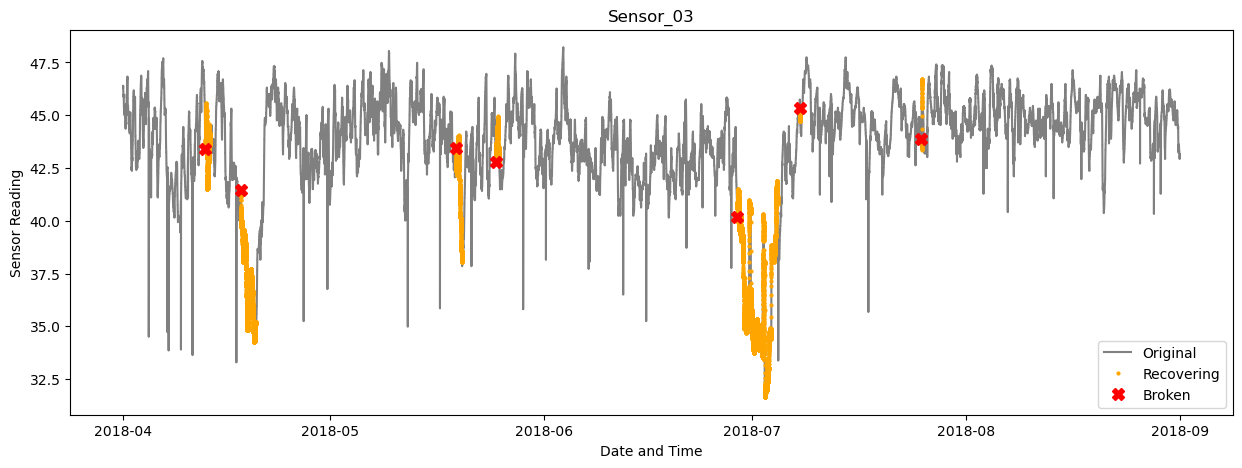

In [6]:
broken = df[df['machine_status']=='BROKEN']
recovering = df[df['machine_status']=='RECOVERING']
sensor = 'sensor_03'
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df[sensor], color='grey',label='Original')
plt.plot(recovering[sensor], linestyle='none', marker='o', color='orange', markersize=2, label='Recovering')
plt.plot(broken[sensor], linestyle='none', marker='X', color='red', markersize=8, label='Broken')
#ax.axvline(test.index.min(), color='black', ls='--')
#ax.set_facecolor('xkcd:white')
plt.xlabel('Date and Time')
plt.ylabel('Sensor Reading')
plt.title('Sensor_03')
plt.legend(loc='best')
plt.show()

Looking deeper on when the downtime starts, we can see no particular day of the week or day of month but it looks like 6/7 faults happen between 9pm and 5am. So let's create a new column: partofday with Morning (0, 5am-1pm), Afternoon (1, 1pm-9pm), Night (2, 9pm-5am). 

In [7]:
def partofday (row):
    if  5 <= row['hour'] <= 12:
        return 0
    elif 13 <= row['hour'] <= 20:
        return 1
    elif row['hour'] <= 4 or row['hour'] >= 21:
        return 2
    else:
        return 'Other'
df['partofday'] = df.apply (lambda row: partofday(row), axis=1)
df[df['machine_status']=='BROKEN']

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,minute,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,partofday
date,,,,,,,,,,,,,,,,,,,,,
2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,15.082470,...,55,21,3,2,4,2018,102,12,15,2
2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,13.867190,...,30,0,2,2,4,2018,108,18,16,2
2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,14.793110,...,18,3,5,2,5,2018,139,19,20,2
2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,15.596060,...,30,0,4,2,5,2018,145,25,21,2
2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,15.118630,...,0,22,3,2,6,2018,179,28,26,2
2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,0.007234,...,11,0,6,3,7,2018,189,8,27,2
2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,15.053530,...,0,14,2,3,7,2018,206,25,30,1


In [8]:
def normalization(sig):
    normalized_features=MinMaxScaler().fit_transform(sig) 
    return normalized_features

## Conclusion

- We have performed a Proof of Concept to predict downtime or normal operation using an LSTM model.
- As the dataset is unbalanced with a majority of normal operation target data, weights for this class are given lower influence.
- With this method we can predict the major downtime periods based on the most important sensors.
- There seems to be no cyclic relationship between downtime and time of day or day of the week. This makes forecasting the sensor signals quite hard to get right.
- To use model, eventually it is recommended to train the model with the complete dataset.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Seleccionar la columna del sensor
sensor_data = df['sensor_03'].values  # Cambia 'sensor_03' al nombre de tu sensor

# 2. Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
sensor_data = scaler.fit_transform(sensor_data.reshape(-1, 1))

# 3. Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(sensor_data) * 0.8)
test_size = len(sensor_data) - train_size
train, test = sensor_data[0:train_size,:], sensor_data[train_size:len(sensor_data),:]

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Definir el número de pasos de tiempo
time_steps = 3

# Crear los conjuntos de entrenamiento y prueba
X_train, y_train = create_dataset(pd.DataFrame(train), pd.DataFrame(train), time_steps)
X_test, y_test = create_dataset(pd.DataFrame(test), pd.DataFrame(test), time_steps)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

OPTIMIZER = Adam(learning_rate=0.01)

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(75))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1))
model.compile(loss='mse', optimizer=OPTIMIZER)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 75)                4875      
                                                                 
 dropout (Dropout)           (None, 75)                0         
                                                                 
 batch_normalization (BatchN  (None, 75)               300       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1)                 76        
                                                                 
Total params: 22,147
Trainable params: 21,997
Non-trainable params: 150
__________________________________________________

In [11]:
# Ajustar el modelo
model.fit(X_train, y_train, epochs=20, verbose=1)

# Imprimir el resumen del modelo

Epoch 1/20
5508/5508 [==============================] - 33s 5ms/step - loss: 0.0040
Epoch 2/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0014
Epoch 3/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0015
Epoch 4/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 5/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 6/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0014
Epoch 7/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 8/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 9/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 10/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0014
Epoch 11/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 12/20
5508/5508 [==============================] - 25s 5ms/step - lo

1377/1377 [==============================] - 3s 2ms/step


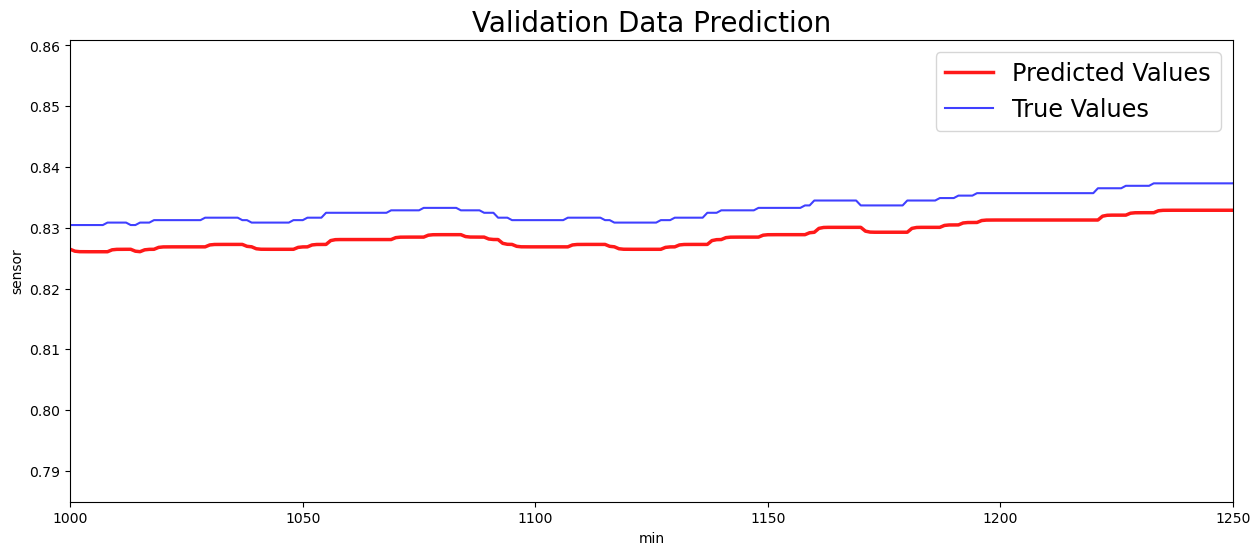

In [12]:
# Reemplaza 'train' con tus datos de entrenamiento y 'sensor_data' con la columna de tu sensor
poll = np.array(train)

poll_mean = poll.mean()
poll_std = poll.std()

# Reemplaza 'y_test' con tus datos de validación
y_val_true = y_test
val_pred = model.predict(X_test).ravel()

y_val_true = y_val_true*poll_std + poll_mean
val_pred = val_pred*poll_std + poll_mean

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("sensor")
plt.xlabel("min")
plt.plot(val_pred, c = "r", alpha = 0.90, linewidth = 2.5)
plt.plot(y_val_true, c = "b", alpha = 0.75)
plt.title("Validation Data Prediction", fontsize=20)
plt.legend(['Predicted Values', 'True Values'], fontsize='xx-large')
plt.show()

In [13]:

from sklearn.metrics import mean_absolute_error , mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val_true, val_pred))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 0.0044413322767131325


Epoch 1/20
5508/5508 [==============================] - 25s 5ms/step - loss: 2.7700e-04
Epoch 2/20
5508/5508 [==============================] - 26s 5ms/step - loss: 2.8028e-04
Epoch 3/20
5508/5508 [==============================] - 26s 5ms/step - loss: 2.8620e-04
Epoch 4/20
5508/5508 [==============================] - 25s 5ms/step - loss: 2.7662e-04
Epoch 5/20
5508/5508 [==============================] - 26s 5ms/step - loss: 2.8321e-04
Epoch 6/20
5508/5508 [==============================] - 26s 5ms/step - loss: 3.0505e-04
Epoch 7/20
5508/5508 [==============================] - 25s 5ms/step - loss: 2.8564e-04
Epoch 8/20
5508/5508 [==============================] - 26s 5ms/step - loss: 2.8576e-04
Epoch 9/20
5508/5508 [==============================] - 25s 5ms/step - loss: 2.9615e-04
Epoch 10/20
5508/5508 [==============================] - 26s 5ms/step - loss: 2.8214e-04
Epoch 11/20
5508/5508 [==============================] - 26s 5ms/step - loss: 2.9837e-04
Epoch 12/20
5508/5508 [=======

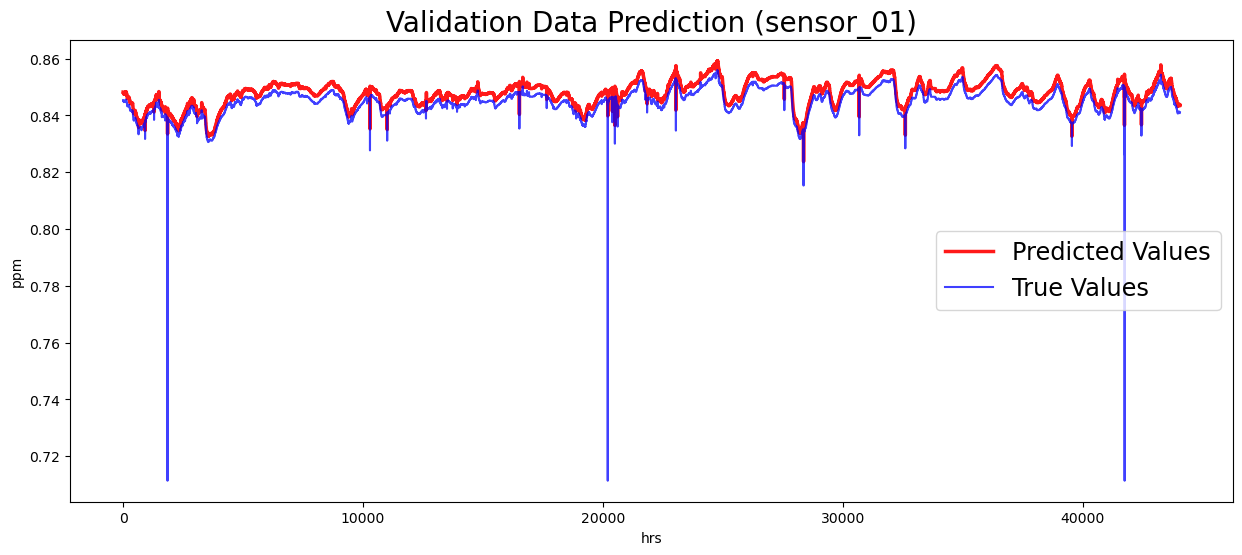

Epoch 1/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0020
Epoch 2/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0019
Epoch 3/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0019
Epoch 4/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0019
Epoch 5/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0020
Epoch 6/20
5508/5508 [==============================] - 27s 5ms/step - loss: 0.0018
Epoch 7/20
5508/5508 [==============================] - 27s 5ms/step - loss: 0.0019
Epoch 8/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0019
Epoch 9/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0019
Epoch 10/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0019
Epoch 11/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0019
Epoch 12/20
5508/5508 [==============================] - 26s 5ms/step - lo

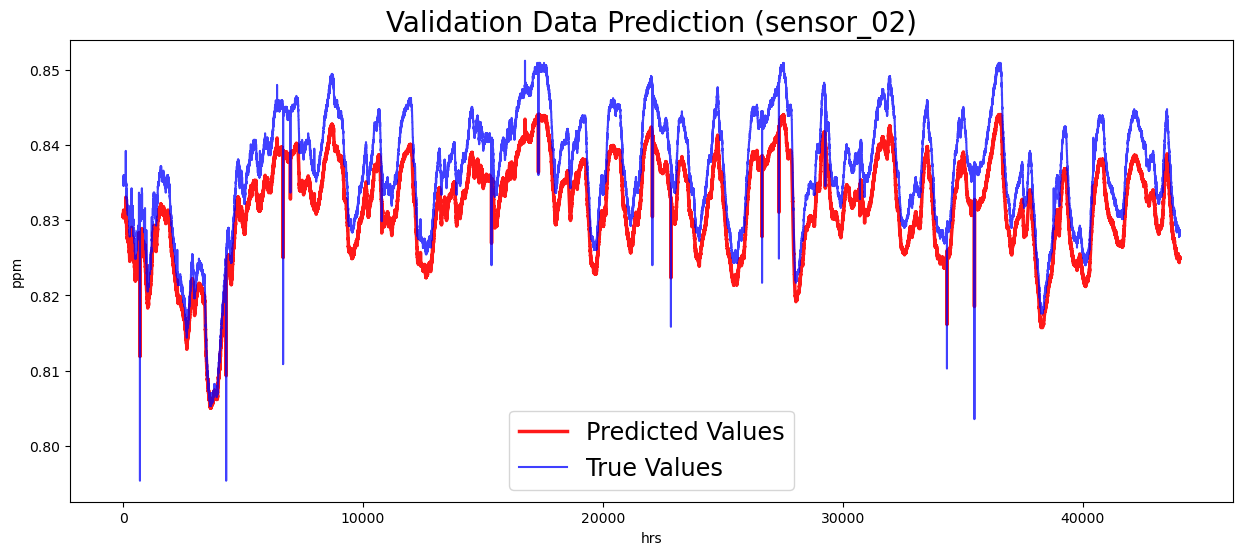

Epoch 1/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0014
Epoch 2/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0015
Epoch 3/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0015
Epoch 4/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 5/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 6/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 7/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0015
Epoch 8/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 9/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0014
Epoch 10/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0014
Epoch 11/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0014
Epoch 12/20
5508/5508 [==============================] - 26s 5ms/step - lo

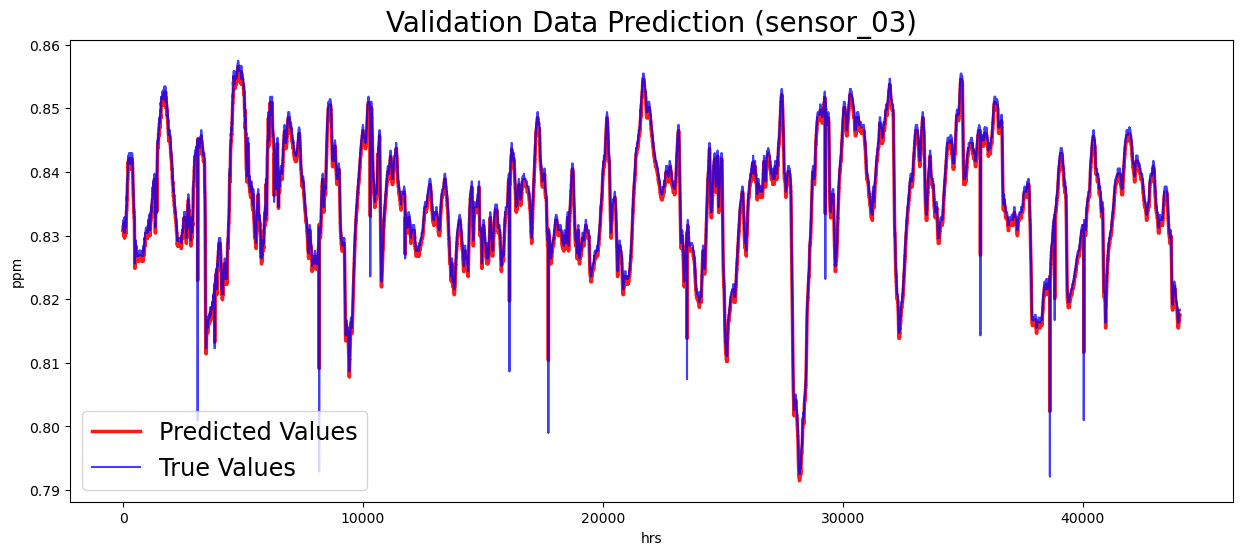

Epoch 1/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0025
Epoch 2/20
5508/5508 [==============================] - 27s 5ms/step - loss: 0.0024
Epoch 3/20
5508/5508 [==============================] - 27s 5ms/step - loss: 0.0024
Epoch 4/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0024
Epoch 5/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0024
Epoch 6/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0024
Epoch 7/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0024
Epoch 8/20
5508/5508 [==============================] - 25s 5ms/step - loss: 0.0025
Epoch 9/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0023
Epoch 10/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0024
Epoch 11/20
5508/5508 [==============================] - 26s 5ms/step - loss: 0.0024
Epoch 12/20
5508/5508 [==============================] - 25s 5ms/step - lo

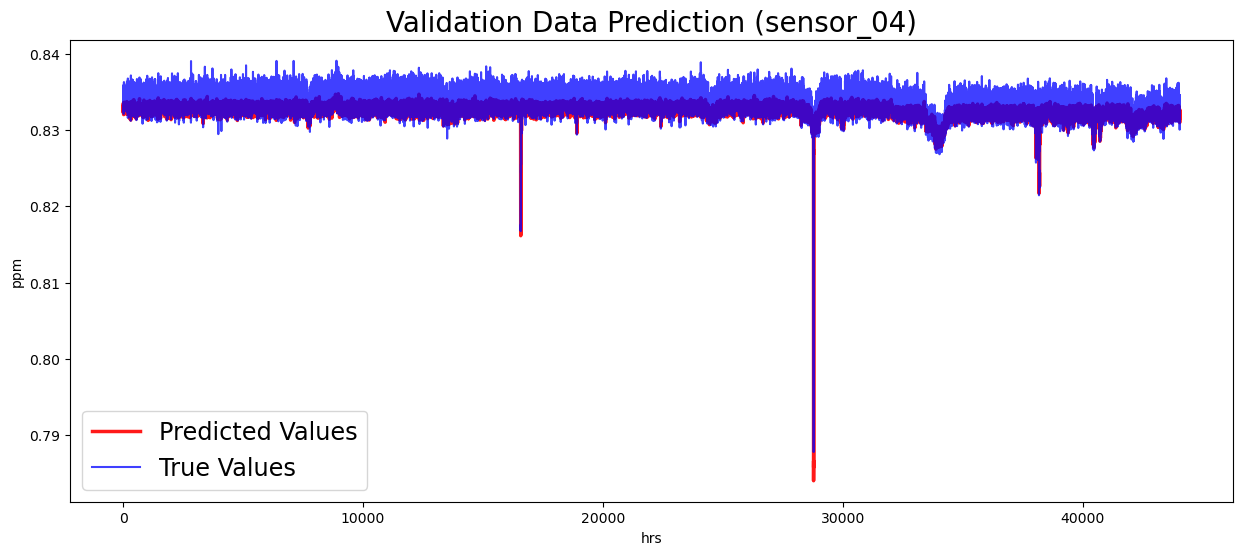

In [14]:
def plot_sensor(sensor_name):
    # Seleccionar la columna del sensor
    sensor_data = df[sensor_name].values

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    sensor_data = scaler.fit_transform(sensor_data.reshape(-1, 1))

    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_size = int(len(sensor_data) * 0.8)
    test_size = len(sensor_data) - train_size
    train, test = sensor_data[0:train_size,:], sensor_data[train_size:len(sensor_data),:]

    # Crear los conjuntos de entrenamiento y prueba
    X_train, y_train = create_dataset(pd.DataFrame(train), pd.DataFrame(train), time_steps)
    X_test, y_test = create_dataset(pd.DataFrame(test), pd.DataFrame(test), time_steps)

    # Ajustar el modelo
    model.fit(X_train, y_train, epochs=20, verbose=1)

    # Realizar predicciones
    y_val_true = y_test
    val_pred = model.predict(X_test).ravel()

    # Desnormalizar las predicciones y los valores verdaderos
    y_val_true = y_val_true*poll_std + poll_mean
    val_pred = val_pred*poll_std + poll_mean

    # Graficar las predicciones y los valores verdaderos
    plt.figure(figsize=(15,6))
    plt.ylabel("ppm")
    plt.xlabel("hrs")
    plt.plot(val_pred, c = "r", alpha = 0.90, linewidth = 2.5)
    plt.plot(y_val_true, c = "b", alpha = 0.75)
    plt.title(f"Validation Data Prediction ({sensor_name})", fontsize=20)
    plt.legend(['Predicted Values', 'True Values'], fontsize='xx-large')
    plt.show()

# Generar gráficos para los sensores 1 al 4
for i in range(1, 5):
    plot_sensor(f'sensor_{i:02d}')